In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
from prettytable import PrettyTable

warnings.filterwarnings( "ignore")
sns.set_theme(style='whitegrid', palette='pastel')

# **1. Substantiation of chosen subsample**

Loading and showing head of dataset

In [3]:
path = 'https://drive.google.com/file/d/1i_VkX57he5_QICWnX-egL2AHpW0yEDvd/view?usp=share_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]

dataframe = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
dataframe.drop(dataframe.columns[0], axis=1, inplace=True)

dataframe.head()

,id,long,lat,light,weather,nearby,road_conditions,category,severity,datetime,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1561495,37.608056,55.689444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Крупный торгов...","['Заснеженное', 'Отсутствие, плохая различимос...",Наезд на препятствие,С погибшими,2015-01-01 00:23:00,...,-10,12,100,96,0.0,1011,-6,2,263,9
1,2365887,91.543006,55.361608,"В темное время суток, освещение не включено",['Ясно'],[],['Сухое'],Наезд на препятствие,Тяжёлый,2015-01-01 00:50:00,...,-16,15,68,96,0.0,1025,-12,2,212,7
2,1561392,37.752778,55.661667,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Нерегулируемый...",['Обработанное противогололедными материалами'],Наезд на пешехода,Тяжёлый,2015-01-01 01:00:00,...,-10,16,100,96,0.0,1010,-6,3,268,11
3,1913663,1.000000,1.000000,"В темное время суток, освещение включено",['Пасмурно'],[],['Мокрое'],Наезд на стоящее ТС,Легкий,2015-01-01 01:15:00,...,-3,22,91,97,0.0,1008,1,5,271,13
4,1561530,37.405833,55.649444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Выезд с прилег...","['Недостатки зимнего содержания', 'Заснеженное']",Столкновение,Тяжёлый,2015-01-01 01:39:00,...,-10,16,100,96,0.0,1010,-6,3,268,11


In [4]:
dataframe[['windspeedKmph', 'humidity', 'pressure', 'time']].head(15)

,windspeedKmph,humidity,pressure,time
0,9,96,1011,00:23:00
1,7,96,1025,00:50:00
2,11,96,1010,01:00:00
3,13,97,1008,01:15:00
4,11,96,1010,01:39:00
5,13,97,1008,02:00:00
6,13,97,1008,02:00:00
7,13,97,1008,02:10:00
8,9,95,1023,02:30:00
9,14,97,1010,03:00:00


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142882 entries, 0 to 142881
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  142882 non-null  int64  
 1   long                142882 non-null  float64
 2   lat                 142882 non-null  float64
 3   light               142882 non-null  object 
 4   weather             142882 non-null  object 
 5   nearby              142882 non-null  object 
 6   road_conditions     142882 non-null  object 
 7   category            142882 non-null  object 
 8   severity            142882 non-null  object 
 9   datetime            142882 non-null  object 
 10  region              142882 non-null  object 
 11  parent_region       142882 non-null  object 
 12  participants_count  142882 non-null  int64  
 13  injured_count       142882 non-null  int64  
 14  dead_count          142882 non-null  int64  
 15  month               142882 non-nul

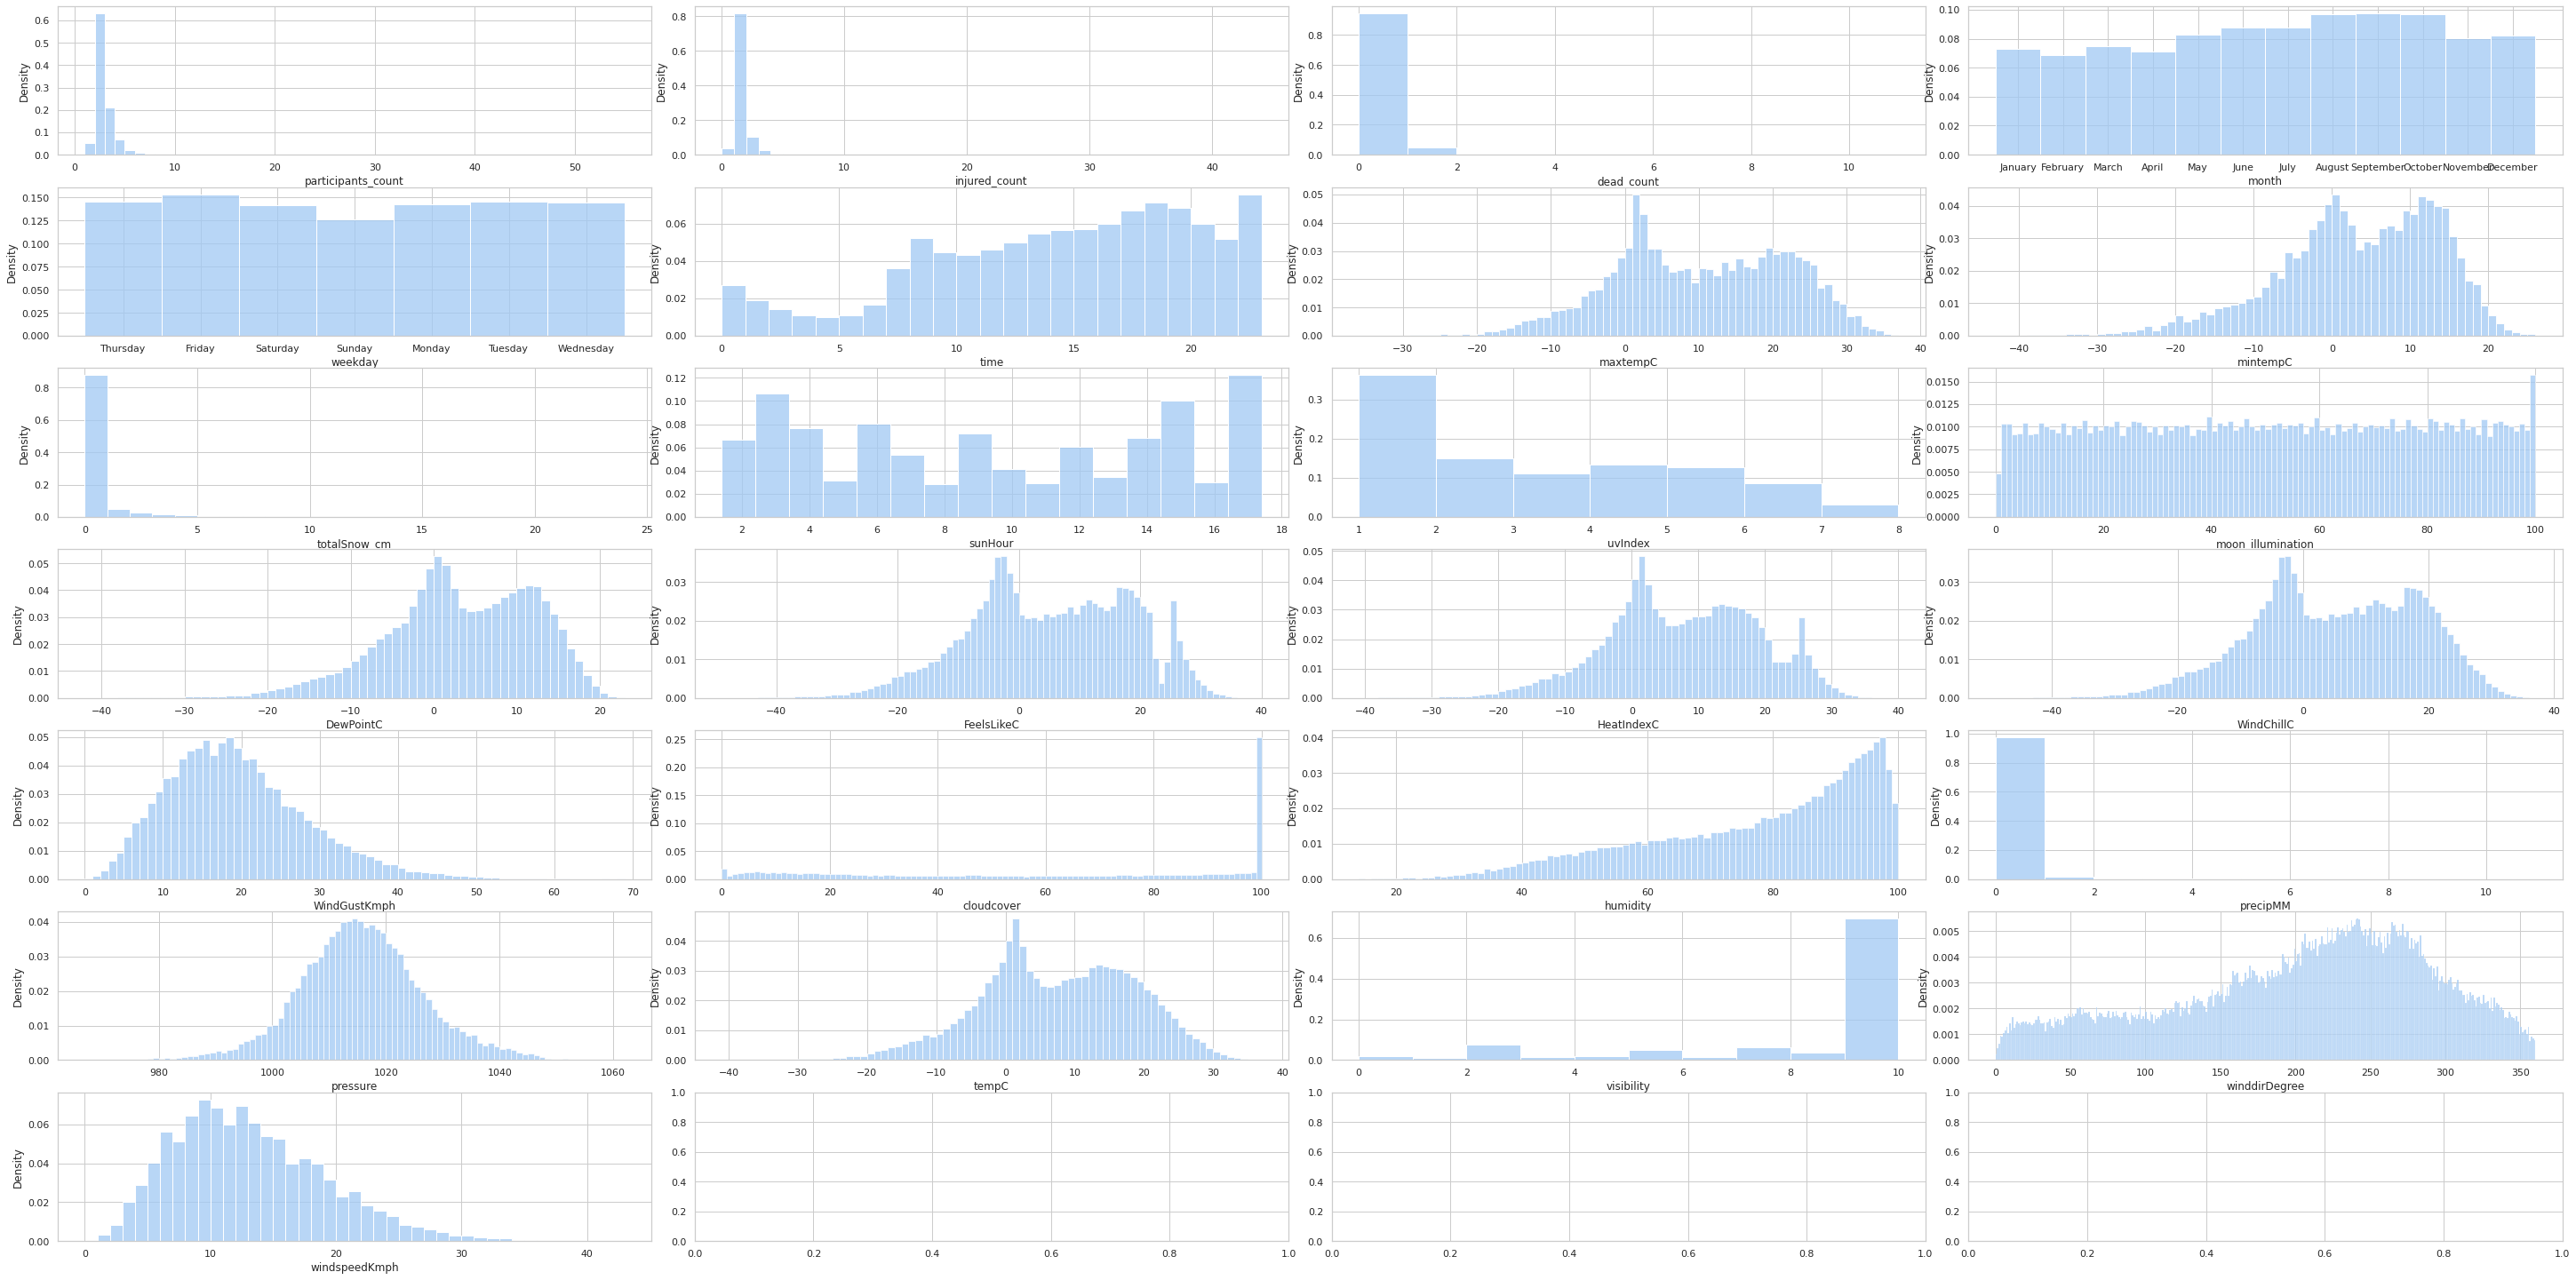

In [10]:
variables = dataframe[['participants_count', 'injured_count', 'dead_count', 'month', 'weekday', 'time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 
           'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 
           'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']]

variables.time = variables.time.apply(lambda elem: int(elem.split(':')[0]))

figure, ax = plt.subplots(7, 4, figsize=(40, 20))
figure.tight_layout()

for index, col in enumerate(variables.columns):
  
  i = index // 4
  j = index % 4

  sns.histplot(variables[col], ax=ax[i, j], binwidth=1, kde=False, stat='density')

plt.show()

# **2. Plotting a non-parametric estimation of PDF in form of a histogram and using kernel density function (or probability law in case of discrete RV)**

In [15]:
def cut_tails(series: pd.Series) -> pd.Series:
  """
    Function that returns input series without "tails"

    :param series: input series
    :type series: pd.Series
    :return: series without "tails"
    :rtype: pd.Series
  """

  q25, q75 = np.percentile(series, [25, 75])
  interval = q75 - q25

  min_dist = q25 - (1.5 * interval)
  max_dist = q75 + (1.5 * interval)

  return series[(series > min_dist) & (series < max_dist)]


def plot_histplot(series: pd.Series, ax: plt.Axes) -> None:
  """
    Function that plots histplot for input series

    :param series: input series
    :param ax: suplot axis
    :type series: pd.Series
    :type ax: plt.Axes
    :return: None 
  """

  sns.histplot(series, ax=ax, binwidth=1, line_kws={"linewidth":5}, kde=True, stat='density')
  plt.xlabel(series.name)

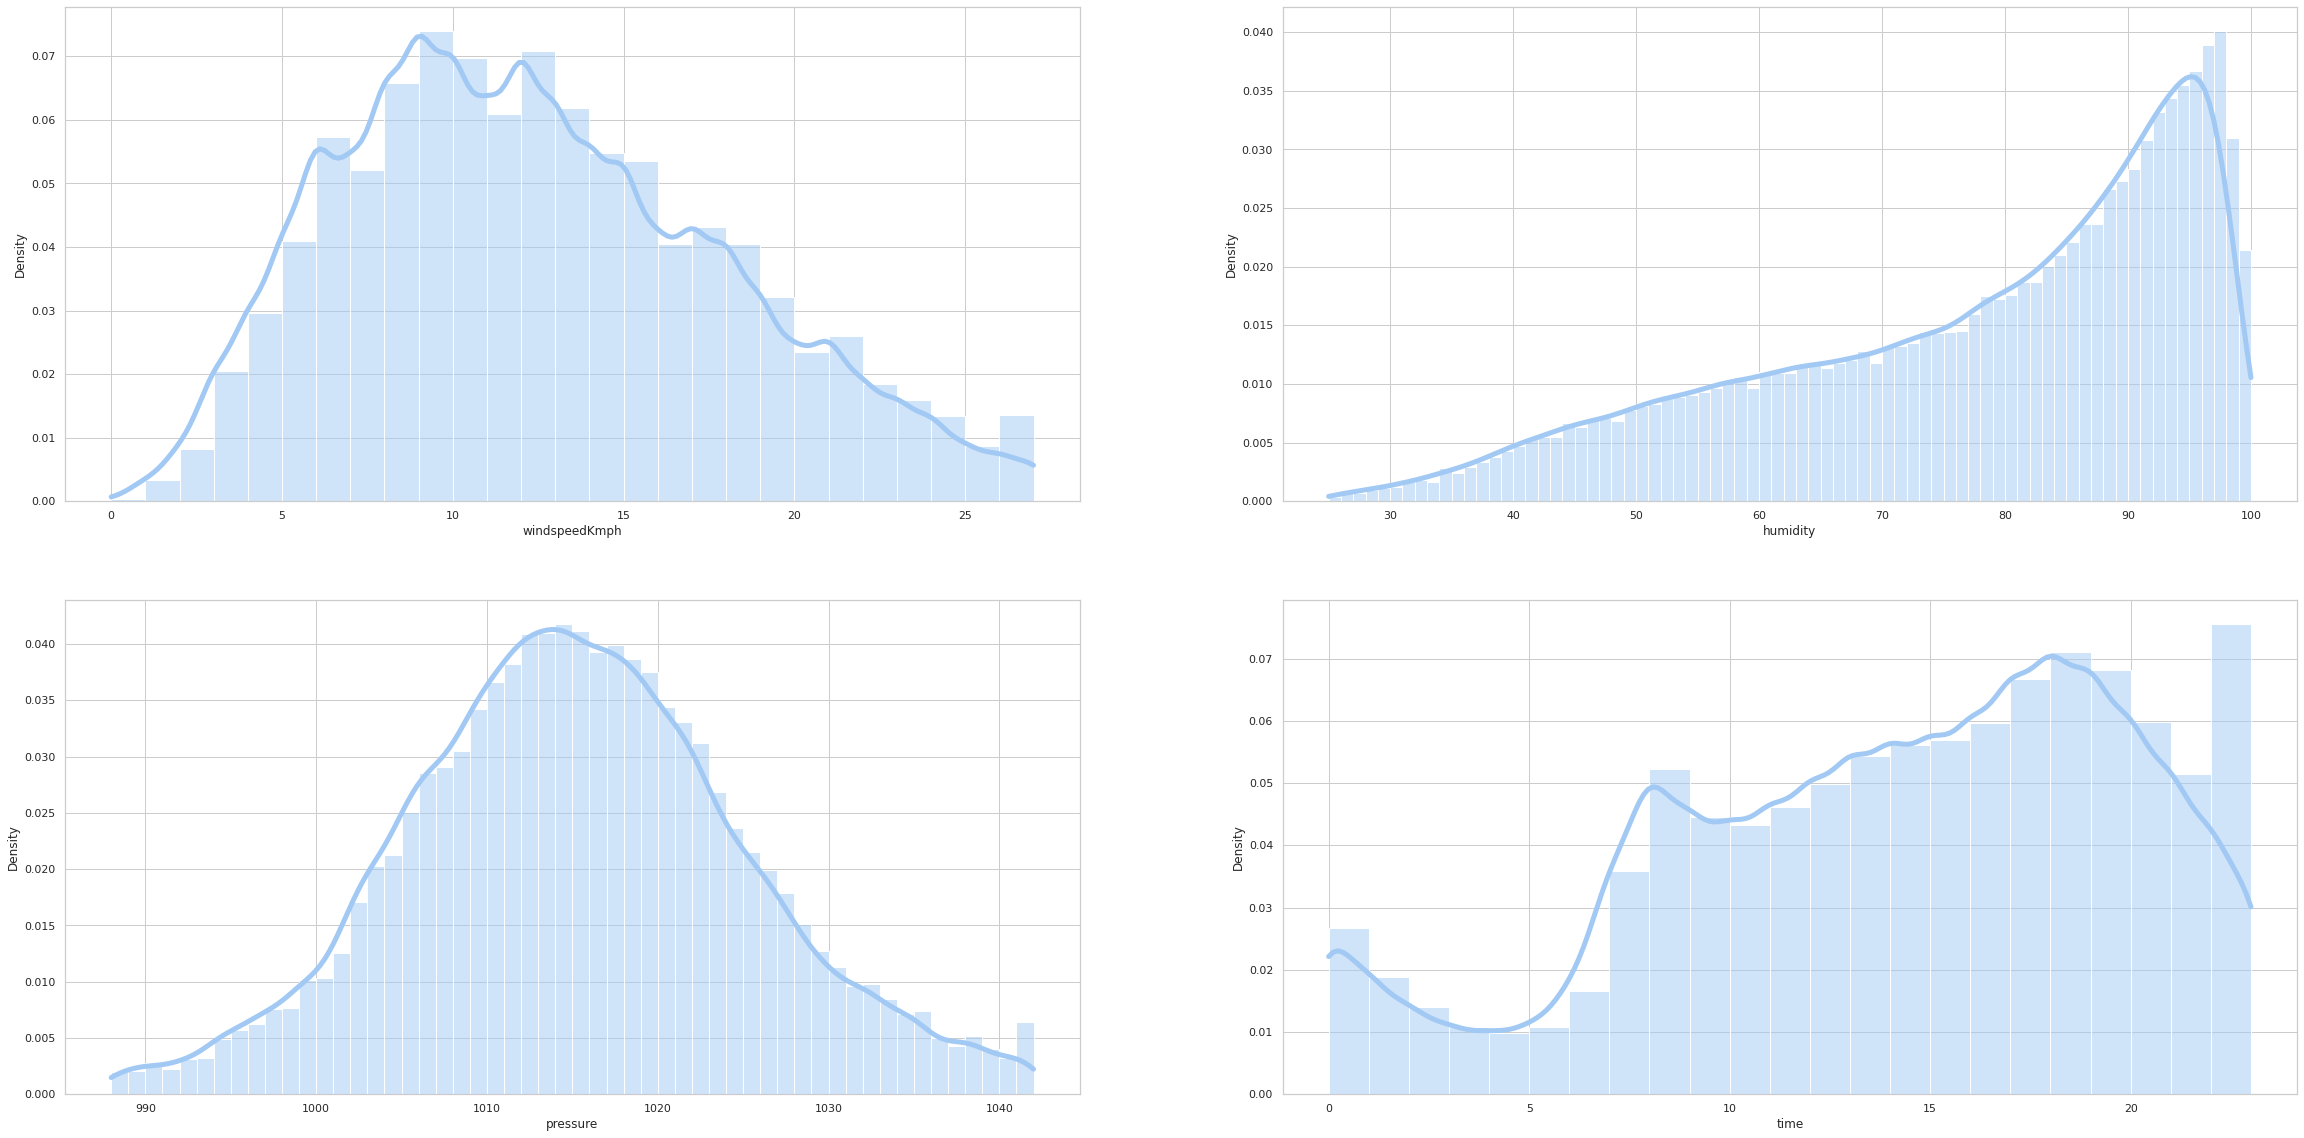

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(40, 20))

plot_histplot(cut_tails(dataframe.windspeedKmph), ax[0, 0])
plot_histplot(cut_tails(dataframe.humidity), ax[0, 1])
plot_histplot(cut_tails(dataframe.pressure), ax[1, 0])
plot_histplot(cut_tails(dataframe.time.apply(lambda elem: int(elem.split(':')[0]))), ax[1, 1])

plt.show()

# **3. Order statistics estimation and its representation as “box with whiskers” plot**

In [ ]:
def return_quantiles(series: pd.Series) -> np.array:
  """
    Function that returns quantiles 10%, 25%, 50%, 75% and 90% of input series

    :param series: input series
    :type series: pd.Series
    :return: quantiles 10%, 25%, 50%, 75% and 90%
    :rtype: np.array
  """

  return np.array([
        np.quantile(series, 0.1),
        np.quantile(series, 0.25),
        np.quantile(series, 0.5),
        np.quantile(series, 0.75),
        np.quantile(series, 0.9)
    ])
  

def plot_histplot_with_boxplot(series: pd.Series, ax_histplot: plt.Axes, ax_boxplot: plt.Axes) -> None:
  """
    Function that plots histplot and boxplot for input series with 10%, 25%, 50%, 75% and 90% quantiles

    :param series: input series
    :param ax_histplot: suplot axis for histplot
    :param ax_boxplot: suplot axis for boxplot
    :type series: pd.Series
    :type ax_histplot: plt.Axes
    :type ax_boxplot: plt.Axes
    :return: None
  """

  sns.histplot(series, ax=ax_histplot, binwidth=1, kde=False, stat='density')
  sns.boxplot(series, ax=ax_boxplot)

  plt.xlabel(series.name)

  quantiles = return_quantiles(series)

  for quantile in quantiles:
    ax_histplot.axvline(quantile, color='blue', linestyle='--')
    ax_boxplot.axvline(quantile, color='blue', linestyle='--')

  print('\n-- ' + series.name + ' --')
  table = PrettyTable(['Quantile', '10%', '25%', '50%', '75%', '90%'])
  table.add_row(['Value', *quantiles])
  print(table)


-- windspeedKmph --
+----------+-----+-----+------+------+------+
| Quantile | 10% | 25% | 50%  | 75%  | 90%  |
+----------+-----+-----+------+------+------+
|  Value   | 5.0 | 8.0 | 12.0 | 16.0 | 20.0 |
+----------+-----+-----+------+------+------+

-- humidity --
+----------+------+------+------+------+------+
| Quantile | 10%  | 25%  | 50%  | 75%  | 90%  |
+----------+------+------+------+------+------+
|  Value   | 50.0 | 65.0 | 82.0 | 92.0 | 96.0 |
+----------+------+------+------+------+------+

-- pressure --
+----------+--------+--------+--------+--------+--------+
| Quantile |  10%   |  25%   |  50%   |  75%   |  90%   |
+----------+--------+--------+--------+--------+--------+
|  Value   | 1003.0 | 1008.0 | 1015.0 | 1022.0 | 1028.0 |
+----------+--------+--------+--------+--------+--------+

-- time --
+----------+-----+------+------+------+------+
| Quantile | 10% | 25%  | 50%  | 75%  | 90%  |
+----------+-----+------+------+------+------+
|  Value   | 6.0 | 10.0 | 15.0 | 1

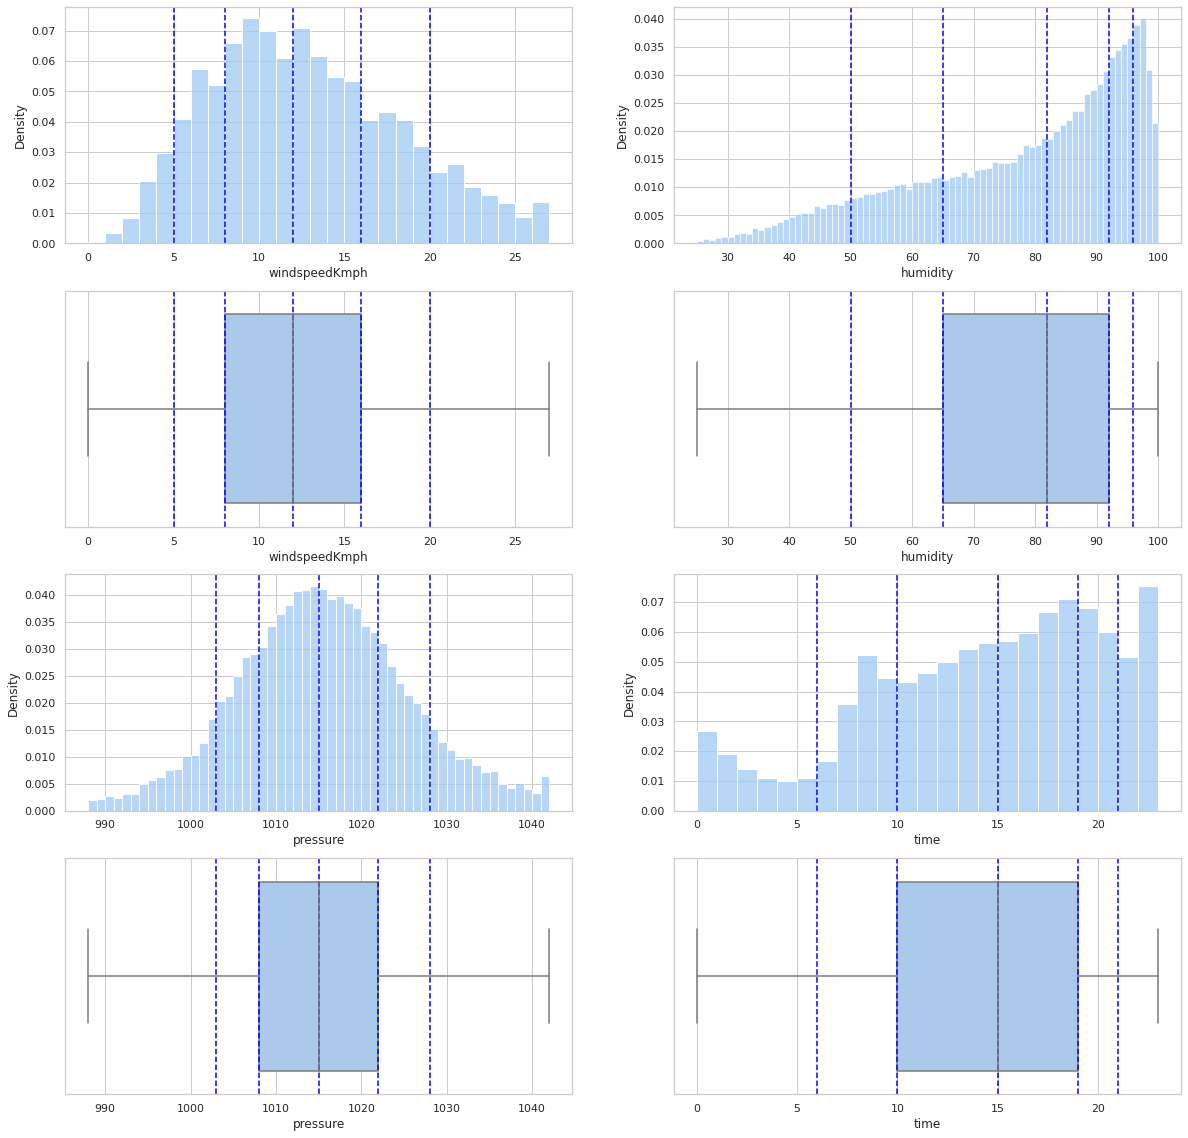

In [ ]:
figure, ax = plt.subplots(4, 2, figsize=(20, 20))

plot_histplot_with_boxplot(cut_tails(dataframe.windspeedKmph), ax[0, 0], ax[1, 0])
plot_histplot_with_boxplot(cut_tails(dataframe.humidity), ax[0, 1], ax[1, 1])
plot_histplot_with_boxplot(cut_tails(dataframe.pressure), ax[2, 0], ax[3, 0])
plot_histplot_with_boxplot(cut_tails(dataframe.time.apply(lambda elem: int(elem.split(':')[0]))), ax[2, 1], ax[3, 1])

plt.show()

# **4. Selection of theoretical distributions that best reflect empirical data + 7. Statistical tests (2 at least)** 

In [ ]:
def plot_theoretical_distributions(series: pd.Series, ax: plt.Axes) -> None:
  """
    Function that plots histplot of input series and fited theoretical distributions

    :param series: input series
    :param ax: suplot axis
    :type series: pd.Series
    :type ax_histplot: plt.Axes
    :return: None
  """

  print('\n-- ' + series.name + ' --')
  
  sns.histplot(series, ax=ax, binwidth=1, kde=False, stat='density')
  plt.xlabel(series.name)
  
  for distribution in ([scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma, scipy.stats.logistic, scipy.stats.lognorm, 
                        scipy.stats.laplace, scipy.stats.argus, scipy.stats.crystalball]):
    
    args_of_distribution = distribution.fit(series)

    x_plot = np.linspace(np.min(series), np.max(series), 100)        
    y_plot = distribution.pdf(x_plot, *args_of_distribution)

    
    sns.lineplot(x_plot, y_plot, ax=ax, label=type(distribution).__name__)
    ax.legend()

    kstest = scipy.stats.kstest(series, distribution(*args_of_distribution).cdf)
    cvm = scipy.stats.cramervonmises(series, distribution(*args_of_distribution).cdf)

    print(f' - {type(distribution).__name__.split("_")[0].capitalize()} distribution parametrs: {args_of_distribution}')
    table = PrettyTable(['Test', 'Kolmogorov test', 'Cramer-von Mises test'])
    table.add_row(['Statistic', kstest.statistic, cvm.statistic])
    table.add_row(['PValue', kstest.pvalue, cvm.pvalue])
    print(table)

  
def samples500(dataframe: pd.DataFrame) -> pd.DataFrame:
  """
    Function that returns 500 random samples of input dataframe

    :param dataframe: input dataframe
    :type dataframe: pd.DataFrame
    :return: dataframe with 500 random samples
    :rtype: pd.DataFrame
  """

  return dataframe.sample(n=500)


-- windspeedKmph --
 - Norm distribution parametrs: (12.309040537845767, 5.59684925309243)
+-----------+---------------------+-----------------------+
|    Test   |   Kolmogorov test   | Cramer-von Mises test |
+-----------+---------------------+-----------------------+
| Statistic | 0.08207948233132095 |   144.11802313234136  |
|   PValue  |         0.0         | 3.058423247992437e-08 |
+-----------+---------------------+-----------------------+
 - Alpha distribution parametrs: (10.033944579185126, -42.713302938833245, 546.5324428012404)
+-----------+----------------------+------------------------+
|    Test   |   Kolmogorov test    | Cramer-von Mises test  |
+-----------+----------------------+------------------------+
| Statistic | 0.055787360533970654 |   62.58962219743766    |
|   PValue  |         0.0          | 1.4785734747668755e-08 |
+-----------+----------------------+------------------------+
 - Gamma distribution parametrs: (8.183477942634635, -3.9610425546174852, 1.988161

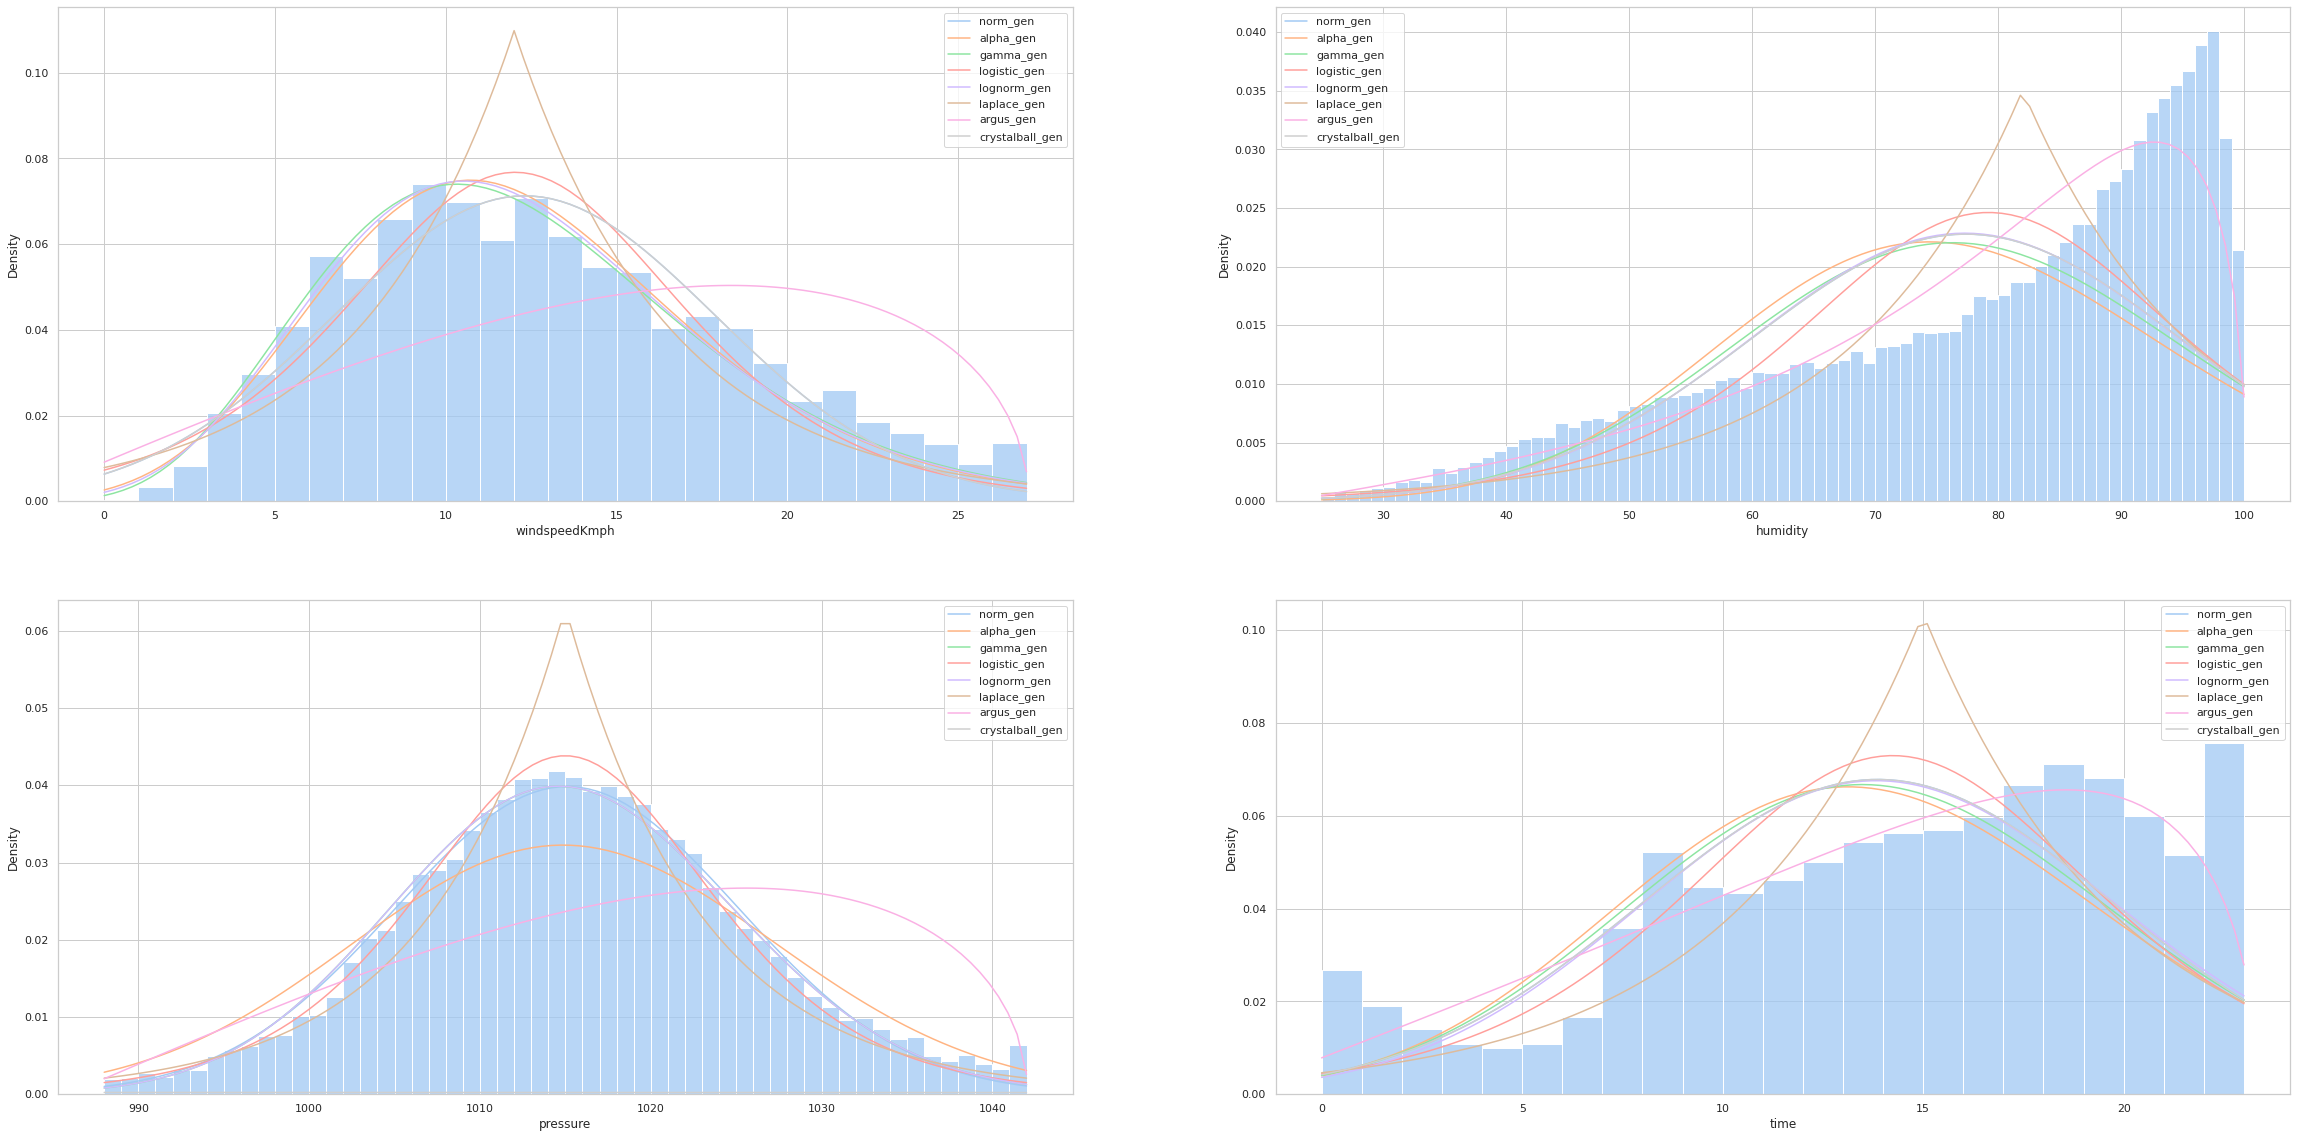

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(40, 20))

plot_theoretical_distributions(cut_tails(dataframe.windspeedKmph), ax[0, 0])
plot_theoretical_distributions(cut_tails(dataframe.humidity), ax[0, 1])
plot_theoretical_distributions(cut_tails(dataframe.pressure), ax[1, 0])
plot_theoretical_distributions(cut_tails(dataframe.time.apply(lambda elem: int(elem.split(':')[0]))), ax[1, 1])

plt.show()


-- windspeedKmph --
 - Norm distribution parametrs: (11.932790224032587, 5.6918103308122525)
+-----------+-----------------------+-----------------------+
|    Test   |    Kolmogorov test    | Cramer-von Mises test |
+-----------+-----------------------+-----------------------+
| Statistic |  0.10134305329439941  |   0.6717212611272589  |
|   PValue  | 7.646174202768604e-05 |  0.014886394781667311 |
+-----------+-----------------------+-----------------------+
 - Alpha distribution parametrs: (7.6875678475377995, -30.258093139601947, 318.72274243315087)
+-----------+----------------------+-----------------------+
|    Test   |   Kolmogorov test    | Cramer-von Mises test |
+-----------+----------------------+-----------------------+
| Statistic | 0.059737688002062805 |   0.2627359016565282  |
|   PValue  | 0.057712137046772805 |  0.17283590661534676  |
+-----------+----------------------+-----------------------+
 - Gamma distribution parametrs: (6.071681923717854, -2.285962287375512, 

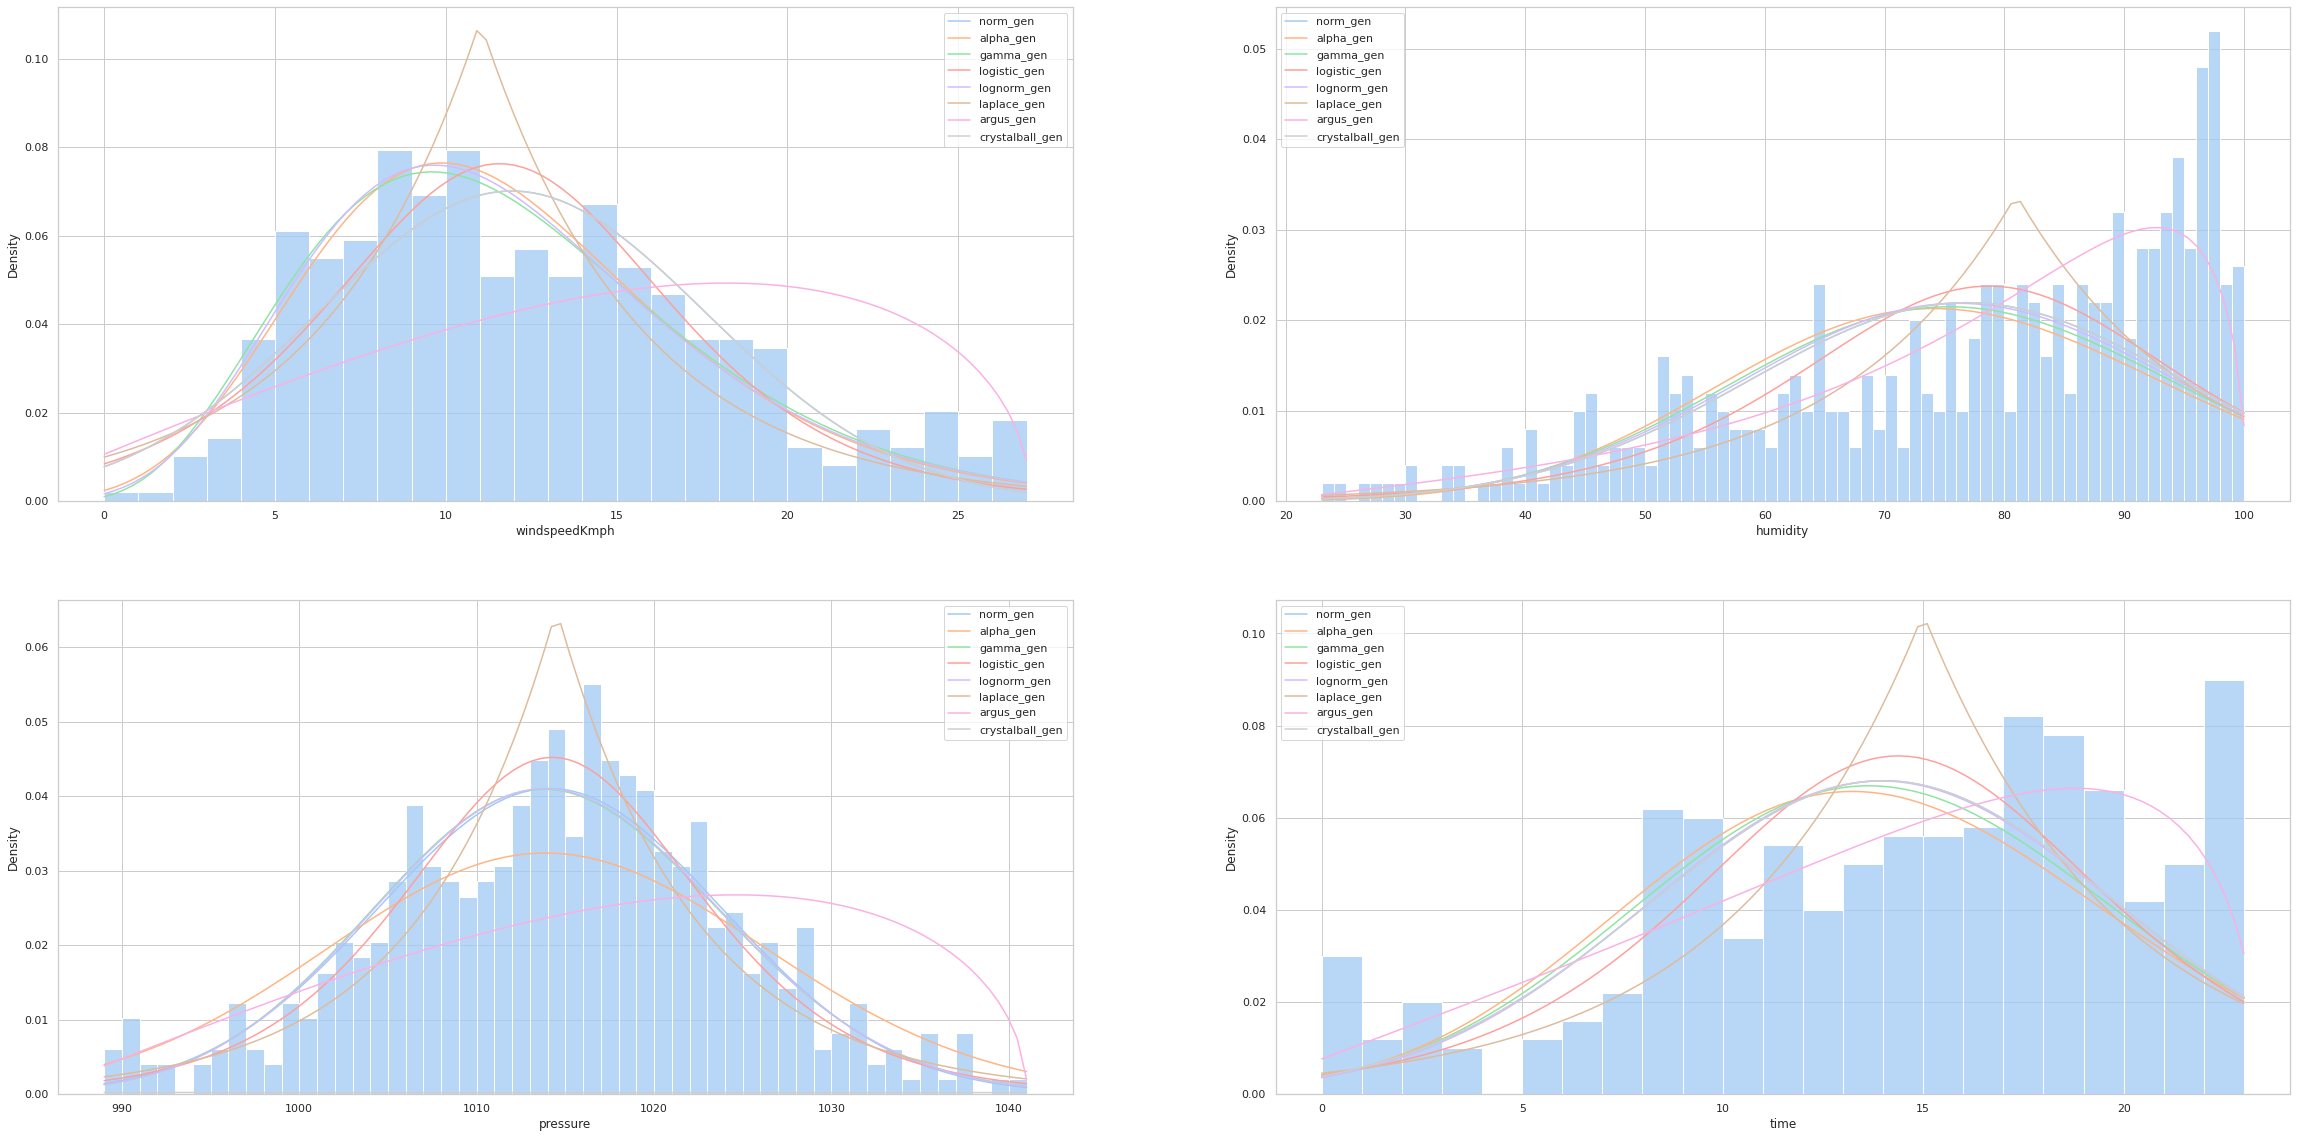

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(40, 20))

dataframe500 = samples500(dataframe)

plot_theoretical_distributions(cut_tails(dataframe500.windspeedKmph), ax[0, 0])
plot_theoretical_distributions(cut_tails(dataframe500.humidity), ax[0, 1])
plot_theoretical_distributions(cut_tails(dataframe500.pressure), ax[1, 0])
plot_theoretical_distributions(cut_tails(dataframe500.time.apply(lambda elem: int(elem.split(':')[0]))), ax[1, 1])

plt.show()

# **5. Estimation of random variable distribution parameters using maximum likelihood technique and LS methods**

In [17]:
def function_gamma(x: pd.Series, a: float, loc: float, scale: float) -> np.array:
  """
    Function that returns elements of PDF of gamma function with input params

    :param x: set of points or values that represent sampled data in the form of array data
    :param a: shape parameter of the gamma distribution
    :param loc: mean
    :param scale: Istandard deviation
    :type x: pd.Series
    :type a: float
    :type loc: float
    :type scale: float
    :return: elements of PDF of gamma function
    :rtype: np.array
  """

  return scipy.stats.gamma.pdf(x, a, loc, scale)


def function_argus(x: pd.Series, chi: float, loc: float, scale: float) -> np.array:
  """
    Function that returns elements of PDF of argus function with input params

    :param x: set of points or values that represent sampled data in the form of array data
    :param chi: chi parameter of the argus distribution
    :param loc: mean
    :param scale: Istandard deviation
    :type x: pd.Series
    :type chi: float
    :type loc: float
    :type scale: float
    :return: elements of PDF of argus function
    :rtype: np.array
  """

  return scipy.stats.argus.pdf(x, chi, loc, scale)


def function_log(x: pd.Series, loc: float, scale: float) -> np.array:
  """
    Function that returns elements of PDF of logistic function with input params

    :param x: set of points or values that represent sampled data in the form of array data
    :param loc: mean
    :param scale: Istandard deviation
    :type x: pd.Series
    :type loc: float
    :type scale: float
    :return: elements of PDF of logistic function
    :rtype: np.array
  """

  return scipy.stats.logistic.pdf(x, loc, scale)


def mle_and_ls(series: pd.Series, distribution: scipy.stats.distributions, ax: plt.Axes) -> None:
  """
    Function that prints estimated parametrs for input theoretical distribution and plots graphs

    :param series: input series
    :param distribution: theoretical distribution
    :param ax: subplot axis
    :type series: pd.Series
    :type distribution: scipy.stats.distributions
    :type ax: plt.Axes
    :return: None
  """

  mlt = distribution.fit(series, method='MLE')

  distribution_name = type(distribution).__name__.split("_")[0]

  ls = []

  ydata, xdata = np.histogram(series, bins=100, density=True)

  xdata = xdata[:-1]
  
  if distribution_name == 'gamma':
    ls, _ = scipy.optimize.curve_fit(function_gamma, xdata=xdata, ydata=ydata, p0=(5, -1, 3), method='lm')
  elif distribution_name == 'argus':
    ls, _ = scipy.optimize.curve_fit(function_argus, xdata=xdata, ydata=ydata, p0=((2, 24, 75) if series.name == 'humidity' else (1, -3, 26)), method='lm')
  elif distribution_name == 'logistic':
    ls, _ = scipy.optimize.curve_fit(function_log, xdata=xdata, ydata=ydata, p0=(1014, 6), method='lm')

  print(f'\n-- {series.name} --')
  print(f'Distribution: {distribution_name}')
  print(f'Maximum likelihood technique parametrs: {" ".join([str(elem) for elem in mlt])}')
  print(f'LS method parametrs: {" ".join([str(elem) for elem in ls])}')


  sns.histplot(series, ax=ax, binwidth=1, kde=True, stat='density', line_kws={"linewidth": 5})
  x_plot = np.linspace(np.min(series), np.max(series), 100)        
  y_plot = distribution.pdf(x_plot, *mlt)
  y_1_plot = distribution.pdf(x_plot, *ls)

  sns.lineplot(x_plot, y_plot, ax=ax, label=type(distribution).__name__ + ' MLE', color='red', linewidth=3)
  sns.lineplot(x_plot, y_1_plot, ax=ax, label=type(distribution).__name__ + ' LS', color='green', linewidth=3)
  ax.legend()


-- windspeedKmph --
Distribution: gamma
Maximum likelihood technique parametrs: 8.183477942634635 -3.9610425546174852 1.9881618800000833
LS method parametrs: 5.087743738816478 -1.6565041298895467 2.8109924417311314

-- humidity --
Distribution: argus
Maximum likelihood technique parametrs: 2.054052129968115 22.309089950530364 77.92500412621871
LS method parametrs: 2.5895181258277398 -0.1679954697552128 100.53547847862818

-- pressure --
Distribution: logistic
Maximum likelihood technique parametrs: 1014.9869983144309 5.702835450812923
LS method parametrs: 1014.4931455227608 6.000578655789957

-- time --
Distribution: argus
Maximum likelihood technique parametrs: 1.2020421647258088 -2.341145253072049 25.683092512914047
LS method parametrs: 1.0841660971857403 -2.4116016154219913 26.25574387220096


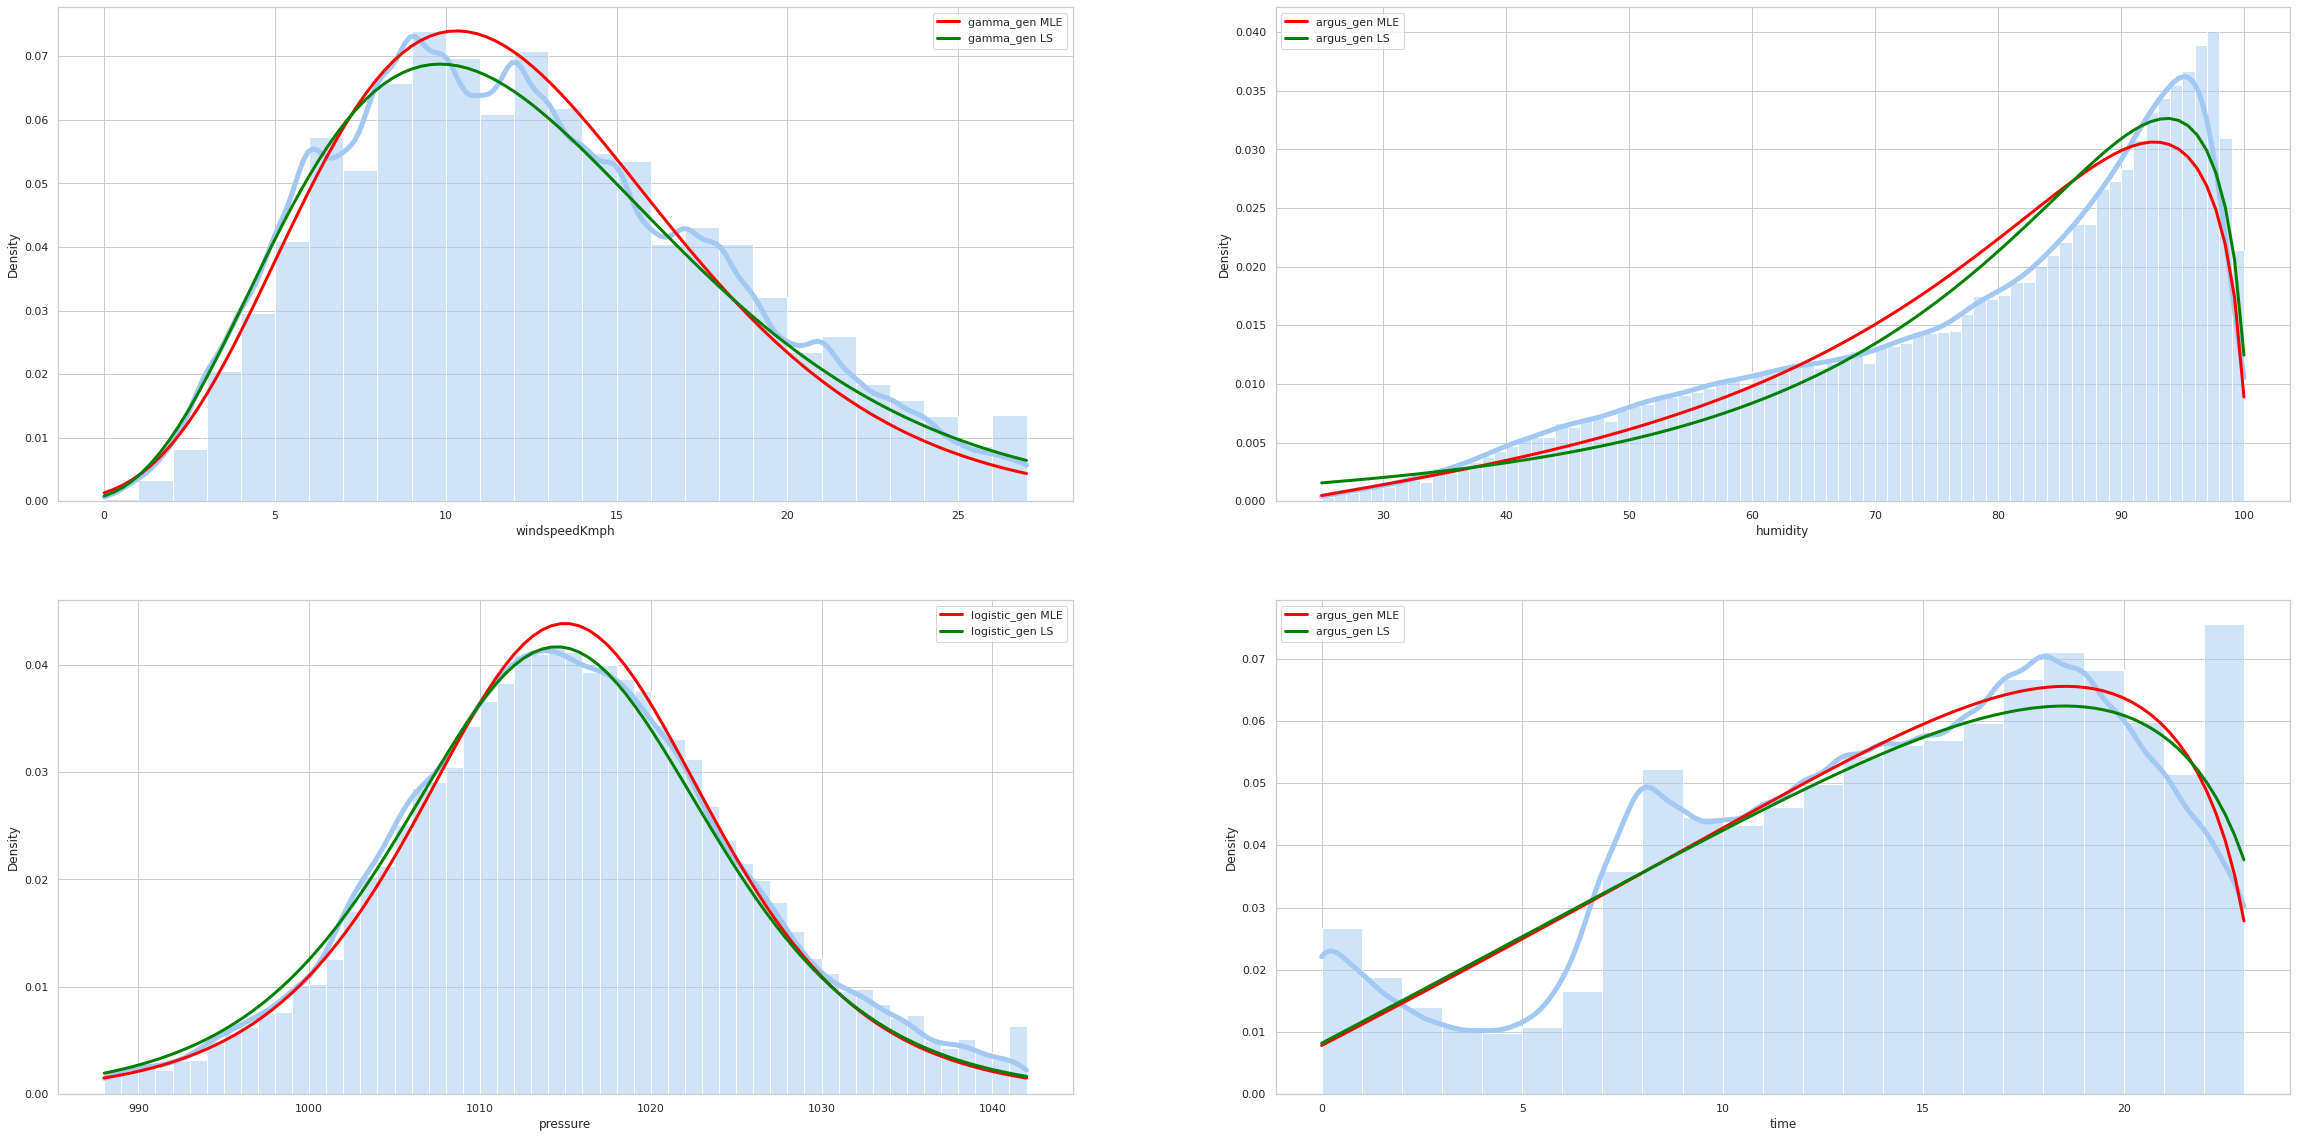

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(40, 20))

mle_and_ls(cut_tails(dataframe.windspeedKmph), scipy.stats.gamma, ax[0, 0])
mle_and_ls(cut_tails(dataframe.humidity), scipy.stats.argus, ax[0, 1])
mle_and_ls(cut_tails(dataframe.pressure), scipy.stats.logistic, ax[1, 0])
mle_and_ls(cut_tails(dataframe.time.apply(lambda elem: int(elem.split(':')[0]))), scipy.stats.argus, ax[1, 1])

plt.show()

# **6. Validation of empirical and theoretical distributions using quantile biplots**

In [13]:
def plot_biplot(series: pd.Series, distribution: scipy.stats, ax_MSE: plt.Axes, ax_LS: plt.Axes) -> None:
  """
    Function to plot quantile biplots by MSE and LS methods

    :param series: input series
    :param distribution: distribution
    :param ax_MSE: subplot axis for MSE method
    :param ax_LS: subplot axis for LS method
    :type series: pd.Series
    :type distribution: scipy.stats
    :type ax_MSE: plt.Axes
    :type ax_LS: plt.Axes
    :return: None
  """

  args_of_distribution = distribution.fit(series)

  distribution_name = type(distribution).__name__.split("_")[0]

  ls = []

  ydata, xdata = np.histogram(series, bins=100, density=True)

  xdata = xdata[:-1]
  
  if distribution_name == 'gamma':
    ls, _ = scipy.optimize.curve_fit(function_gamma, xdata=xdata, ydata=ydata, p0=(5, -1, 3), method='lm')
  elif distribution_name == 'argus':
    ls, _ = scipy.optimize.curve_fit(function_argus, xdata=xdata, ydata=ydata, p0=((2, 24, 75) if series.name == 'humidity' else (1, -3, 26)), method='lm')
  elif distribution_name == 'logistic':
    ls, _ = scipy.optimize.curve_fit(function_log, xdata=xdata, ydata=ydata, p0=(1014, 6), method='lm')

  print(f' - {type(distribution).__name__.split("_")[0].capitalize()} distribution parametrs for {series.name}: {args_of_distribution} MSE')
  print(f' - {type(distribution).__name__.split("_")[0].capitalize()} distribution parametrs for {series.name}: {ls} LS', end='\n\n')

  scipy.stats.probplot(series, dist=distribution, sparams=(args_of_distribution), plot=ax_MSE)
  scipy.stats.probplot(series, dist=distribution, sparams=(tuple(ls)), plot=ax_LS)

 - Gamma distribution parametrs for windspeedKmph: (8.183477942634635, -3.9610425546174852, 1.9881618800000833) MSE
 - Gamma distribution parametrs for windspeedKmph: [ 5.08774374 -1.65650413  2.81099244] LS

 - Argus distribution parametrs for humidity: (2.054052129968115, 22.309089950530364, 77.92500412621871) MSE
 - Argus distribution parametrs for humidity: [  2.58951813  -0.16799547 100.53547848] LS

 - Logistic distribution parametrs for pressure: (1014.9869983144309, 5.702835450812923) MSE
 - Logistic distribution parametrs for pressure: [1014.49314552    6.00057866] LS

 - Argus distribution parametrs for time: (1.2020421647258088, -2.341145253072049, 25.683092512914047) MSE
 - Argus distribution parametrs for time: [ 1.0841661  -2.41160162 26.25574387] LS



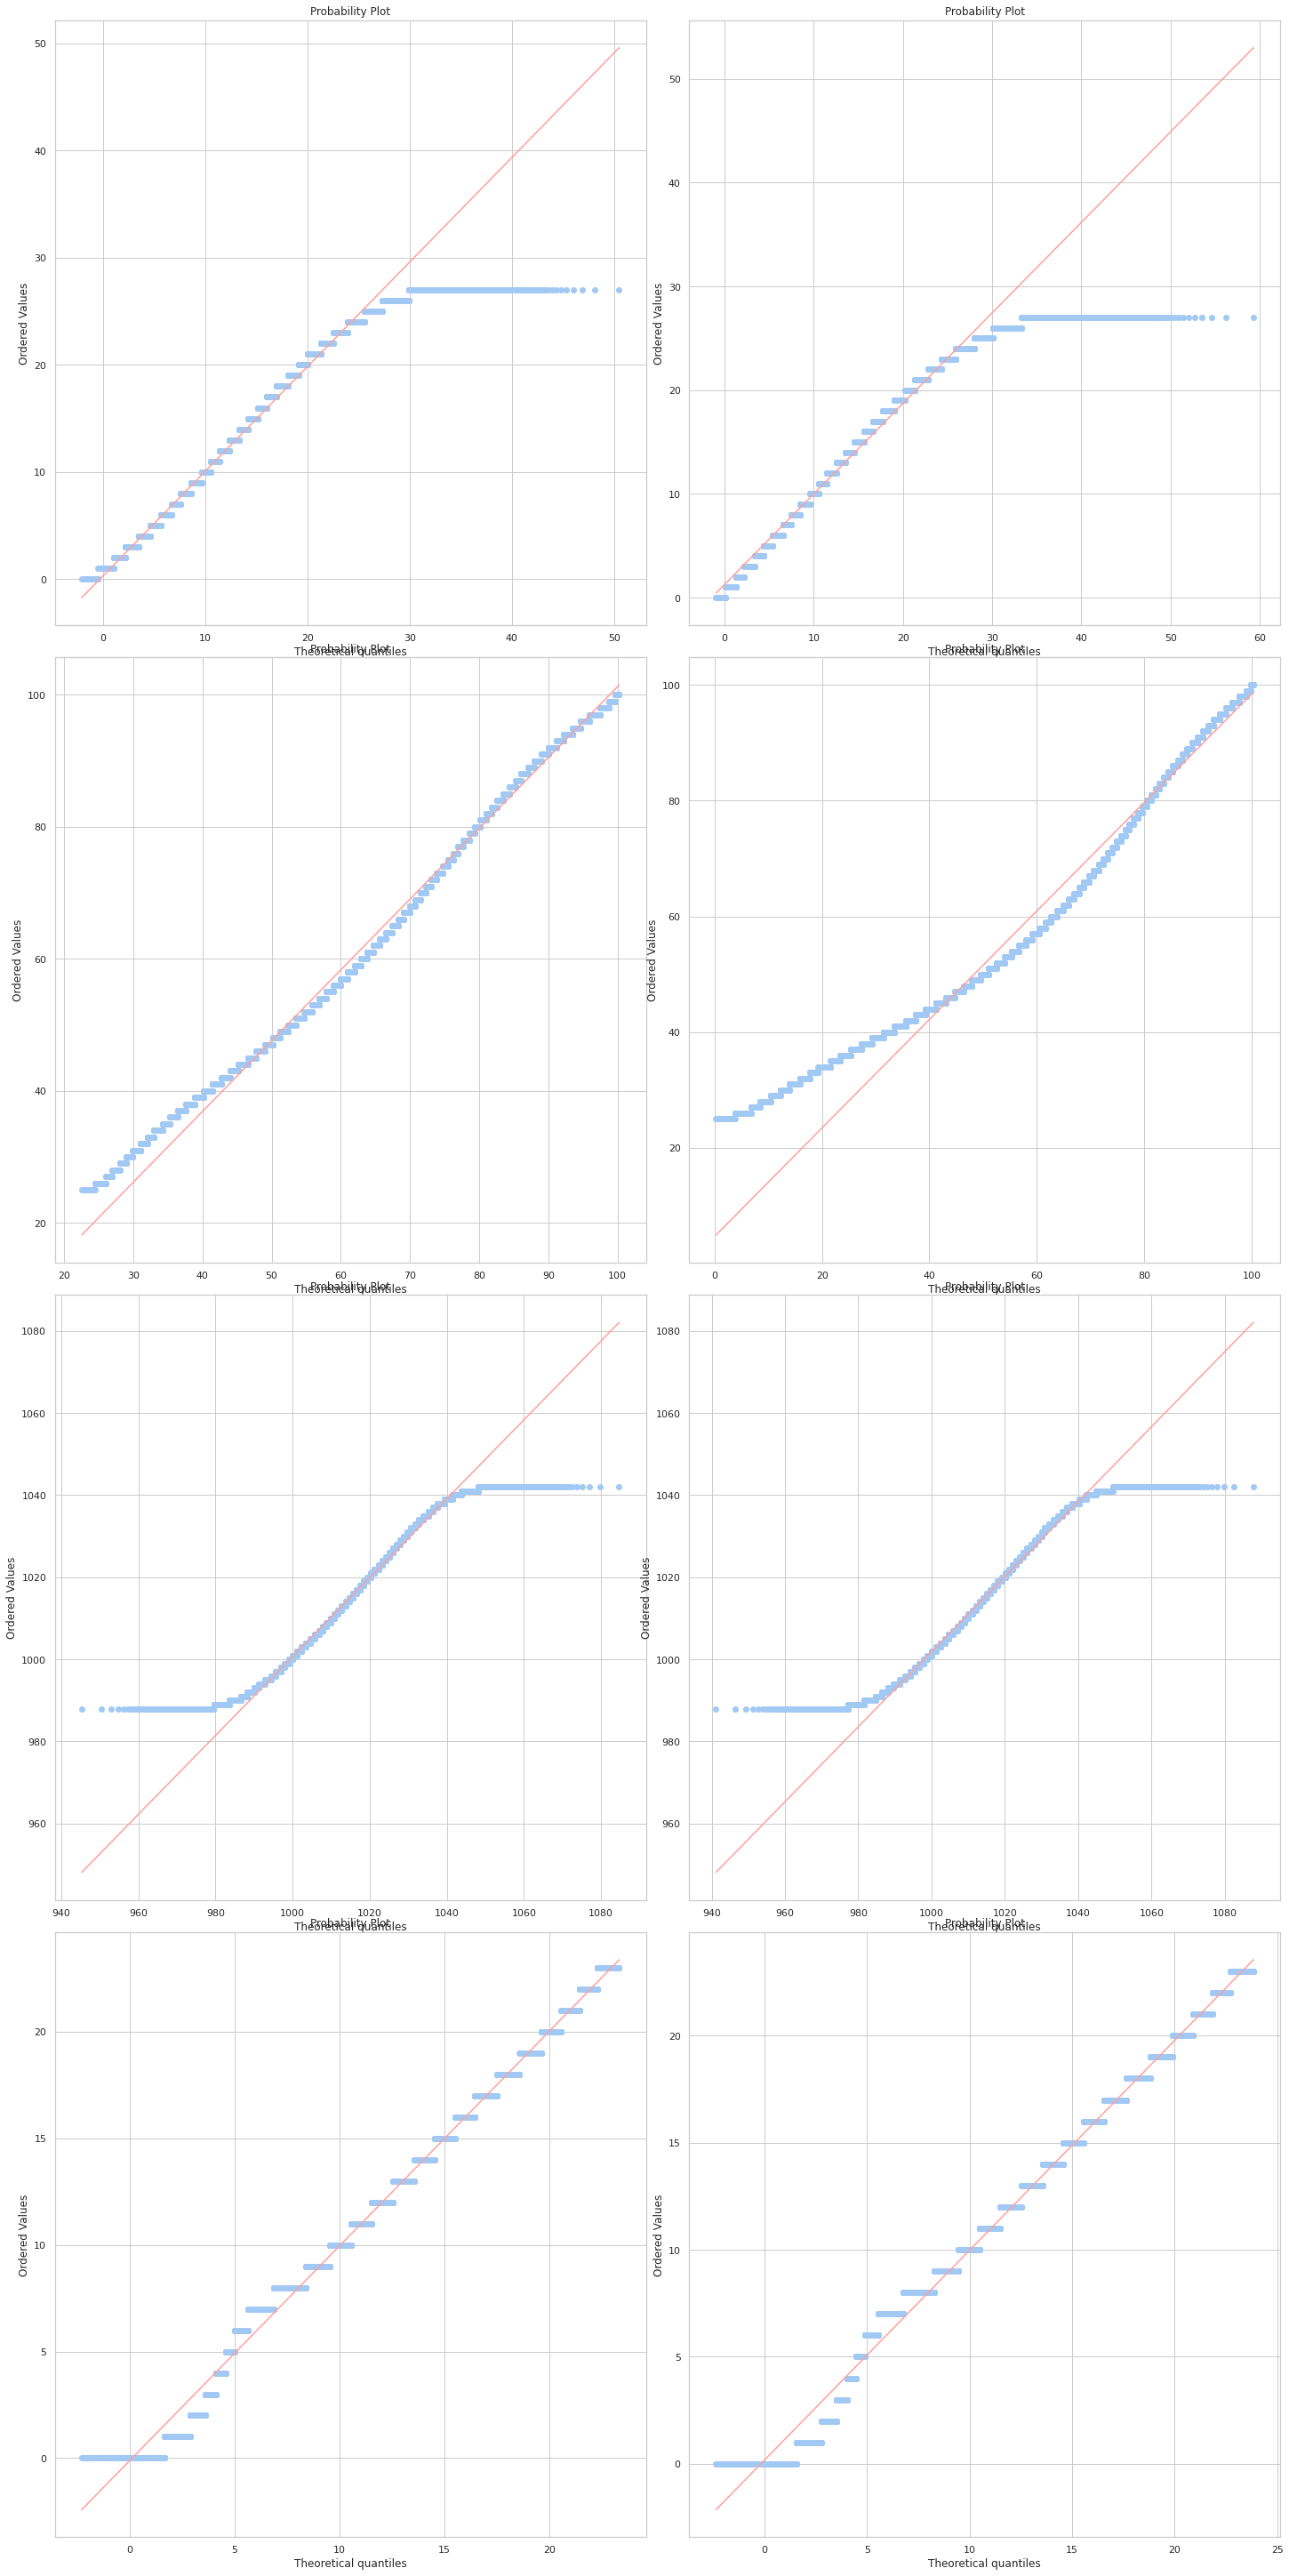

In [19]:
figure, ax = plt.subplots(4, 2, figsize=(20, 40))
figure.tight_layout()

plot_biplot(cut_tails(dataframe.windspeedKmph), scipy.stats.gamma, ax[0, 0], ax[0, 1])
plot_biplot(cut_tails(dataframe.humidity), scipy.stats.argus, ax[1, 0], ax[1, 1])
plot_biplot(cut_tails(dataframe.pressure), scipy.stats.logistic, ax[2, 0], ax[2, 1])
plot_biplot(cut_tails(dataframe.time.apply(lambda elem: int(elem.split(':')[0]))), scipy.stats.argus, ax[3, 0], ax[3, 1])

plt.show()